In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import welch
import wfdb
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# loading data
print("Step 1: Loading Data...")

file_path = r'C:\Users\jalad\Downloads\mit-bih-polysomnographic-database-1.0.0\mit-bih-polysomnographic-database-1.0.0\ANNOTATORS'


with open(file_path, 'r') as file:
    annotations = file.readlines()
    
    for line in annotations:
        print(line)


data_directory = r"C:\Users\jalad\Downloads\mit-bih-polysomnographic-database-1.0.0\mit-bih-polysomnographic-database-1.0.0" 
record_names = [f.split('.')[0] for f in os.listdir(data_directory) if f.endswith('.dat')]

all_records = []
for record_name in record_names:
    record_path = os.path.join(data_directory, record_name)
    
    try:
        
        record = wfdb.rdrecord(record_path)
        signals = record.p_signal
        
        
        sleep_ann = wfdb.rdann(record_path, 'st')
        sleep_annotations = {
            'sample': sleep_ann.sample,
            'symbol': sleep_ann.symbol,
            'description': sleep_ann.aux_note
        }
        
        
        ecg_ann = wfdb.rdann(record_path, 'ecg')  
        ecg_annotations = {
            'sample': ecg_ann.sample,
            'symbol': ecg_ann.symbol  
        }
        
        all_records.append({
            'signals': signals,
            'sleep_annotations': sleep_annotations,
            'ecg_annotations': ecg_annotations,  
            'record_name': record_name
        })
        print(f"Successfully loaded record: {record_name}")
    except Exception as e:
        print(f"Error loading record {record_name}: {str(e)}")

print(f"\nTotal records loaded: {len(all_records)}")

def create_labels(annotations):
    label_map = {
        'W': 0,  
        '1': 1, '2': 1, 
        '3': 2, '4': 2, 'R': 2  
    }
    
    labels = []
    for desc in annotations['description']:
        if isinstance(desc, str) and desc.strip():  
            stage = desc.split()[0]  
            label = label_map.get(stage)
            if label is not None:
                labels.append(label)
            else:
                labels.append(0)  
        else:
            labels.append(0)  
    
    return np.array(labels, dtype=np.int32)  

# Preprocess signals 
processed_data = []
for record in all_records:
    
    signals = record['signals']
    signals = (signals - np.mean(signals, axis=0)) / np.std(signals, axis=0)
    
    
    labels = create_labels(record['sleep_annotations'])
    
    
    ecg_symbols = record['ecg_annotations']['symbol']  
    
    # Storing processed data
    processed_data.append({
        'signals': signals,
        'labels': labels,
        'ecg_symbols': ecg_symbols,  
        'record_name': record['record_name']
    })




Step 1: Loading Data...
ecg	automatically generated beat annotations, with some corrections

st	reference sleep stage and apnea annotations (at 30 sec intervals)

Successfully loaded record: slp01a
Successfully loaded record: slp01b
Successfully loaded record: slp02a
Successfully loaded record: slp02b
Successfully loaded record: slp03
Successfully loaded record: slp04
Successfully loaded record: slp14
Successfully loaded record: slp16
Successfully loaded record: slp32
Successfully loaded record: slp37
Successfully loaded record: slp41
Successfully loaded record: slp45
Successfully loaded record: slp48
Successfully loaded record: slp59
Successfully loaded record: slp60
Successfully loaded record: slp61
Successfully loaded record: slp66
Successfully loaded record: slp67x

Total records loaded: 18


In [2]:
# Displaying the processed data for each record
print("\nProcessed Data:")
for record in processed_data:
    print(f"Record: {record['record_name']}")
    print(f"Signals (first 5 samples): \n{record['signals'][:5]}")  # Showing first 5 samples 
    print(f"Labels (first 5): {record['labels'][:5]}")  
    print(f"ECG Symbols (first 5): {record['ecg_symbols'][:5]}")  # Showing first 5 ECG symbols
    print("="*50)  



Processed Data:
Record: slp01a
Signals (first 5 samples): 
[[-0.09516855 -0.99565618 -0.60389167 -0.60800801]
 [-0.12948638 -1.0060945  -0.59373352 -0.61980585]
 [ 0.17937409 -0.99565618 -0.58357537 -0.60800801]
 [ 0.48823456 -1.0060945  -0.60897075 -0.62865423]
 [ 0.90004852 -1.02697115 -0.47691479 -0.61685639]]
Labels (first 5): [2 2 2 2 2]
ECG Symbols (first 5): ['N', 'N', 'N', 'N', 'N']
Record: slp01b
Signals (first 5 samples): 
[[ 0.77639428  0.10748037  1.60461824 -0.82572323]
 [ 0.87187583  0.21753809  1.63947007 -0.81904402]
 [ 0.80822146  0.32759581  1.65689599 -0.83574205]
 [ 0.90370302  0.42918755  1.70917374 -0.86579848]
 [ 0.84004865  0.53077929  1.67432191 -0.84242125]]
Labels (first 5): [1 1 1 1 1]
ECG Symbols (first 5): ['N', 'N', 'N', 'N', 'N']
Record: slp02a
Signals (first 5 samples): 
[[-0.77748077  0.0710552   0.58905306  0.3819275 ]
 [-0.77748077  0.06409907  0.59700607  0.40042245]
 [-0.81031063  0.06409907  1.54341412  0.40966993]
 [-0.77748077  0.06409907  0.67

In [3]:
# Displaying a few records with their corresponding labels
if all_records:
    
    for i, record in enumerate(all_records[:5]):  # Displaying the first 5 records
        print(f"Record {i+1}:")
        print(record)
        print()  
else:
    print("No records loaded.")


Record 1:
{'signals': array([[ 8.50000000e-02,  4.79302103e+01, -3.91912908e-02,
        -2.60869565e-01],
       [ 8.00000000e-02,  4.77209080e+01, -3.88802488e-02,
        -2.66666667e-01],
       [ 1.25000000e-01,  4.79302103e+01, -3.85692068e-02,
        -2.60869565e-01],
       ...,
       [ 2.30000000e-01,  7.86976378e+01,  1.47278383e-01,
         3.82608696e-01],
       [ 2.35000000e-01,  8.20464735e+01,  1.46811820e-01,
         3.81159420e-01],
       [ 2.25000000e-01,  8.56046113e+01,  1.42612753e-01,
         3.76811594e-01]]), 'sleep_annotations': {'sample': array([      1,    7500,   15000,   22500,   30000,   37500,   45000,
         52500,   60000,   67500,   75000,   82500,   90000,   97500,
        105000,  112500,  120000,  127500,  135000,  142500,  150000,
        157500,  165000,  172500,  180000,  187500,  195000,  202500,
        210000,  217500,  225000,  232500,  240000,  247500,  255000,
        262500,  270000,  277500,  285000,  292500,  300000,  307500,
  

Step 2: Preprocessing Completed.

Data shape information:
Number of preprocessed records: 18

Record 1:
Signal shape: (1800000, 4)
Number of labels: 240
Unique labels: [0 1 2]

Record 2:
Signal shape: (2700000, 4)
Number of labels: 360
Unique labels: [0 1 2]

Record 3:
Signal shape: (2700000, 4)
Number of labels: 360
Unique labels: [0 1 2]

Record 4:
Signal shape: (2025000, 4)
Number of labels: 270
Unique labels: [0 1 2]

Record 5:
Signal shape: (5400000, 4)
Number of labels: 720
Unique labels: [0 1 2]

Record 6:
Signal shape: (5400000, 4)
Number of labels: 720
Unique labels: [0 1 2]

Record 7:
Signal shape: (5400000, 4)
Number of labels: 714
Unique labels: [0 1 2]

Record 8:
Signal shape: (5400000, 4)
Number of labels: 694
Unique labels: [0 1 2]

Record 9:
Signal shape: (4800000, 7)
Number of labels: 640
Unique labels: [0 1 2]

Record 10:
Signal shape: (5250000, 7)
Number of labels: 698
Unique labels: [0 1 2]

Record 11:
Signal shape: (5850000, 7)
Number of labels: 780
Unique labels: 

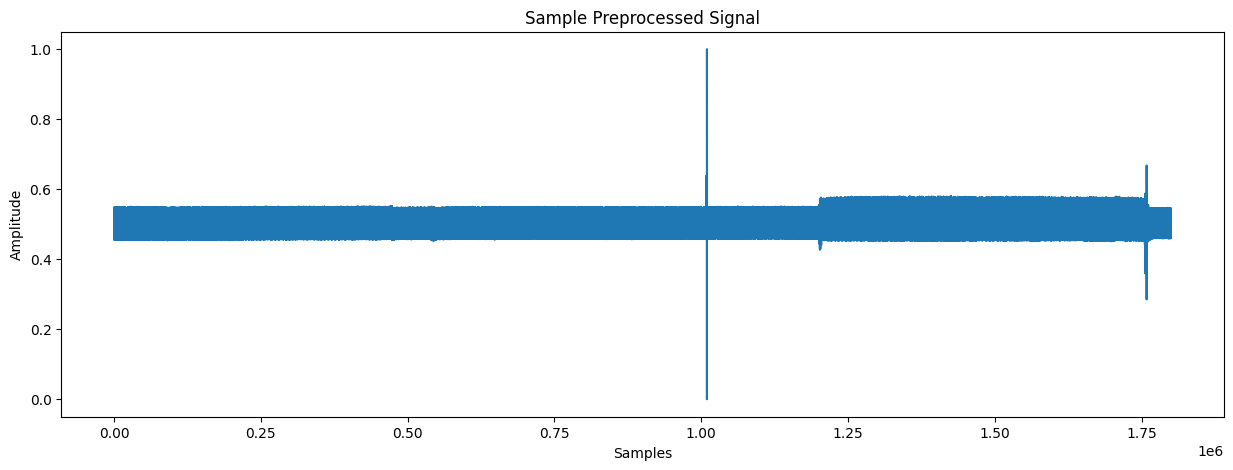

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#  preprocessing functions
def handle_nan_values(signal):
    
    signal = np.where(np.isnan(signal), np.nanmedian(signal), signal)
    return signal

def mean_subtraction(signal):
   
    return signal - np.mean(signal)

def scale_signal(signal):
    
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal  
    return (signal - min_val) / (max_val - min_val)


preprocessed_data = []
for record in processed_data:
    signals = record['signals']
    
    
    signals = handle_nan_values(signals)
    
    
    signals = mean_subtraction(signals)
    
   
    signals = scale_signal(signals)
    
    
    preprocessed_data.append({
        'signals': signals,
        'labels': record['labels']
    })

print("Step 2: Preprocessing Completed.")


print("\nData shape information:")
print(f"Number of preprocessed records: {len(preprocessed_data)}")
for i, record in enumerate(preprocessed_data):
    print(f"\nRecord {i+1}:")
    print(f"Signal shape: {record['signals'].shape}")
    print(f"Number of labels: {len(record['labels'])}")
    print(f"Unique labels: {np.unique(record['labels'])}")


plt.figure(figsize=(15, 5))
plt.plot(preprocessed_data[0]['signals'][:, 0]) 
plt.title('Sample Preprocessed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()


Unique labels in segments: [0, 1, 2]

Label distribution:

Data quality checks:
Number of segments with NaN signals: 0


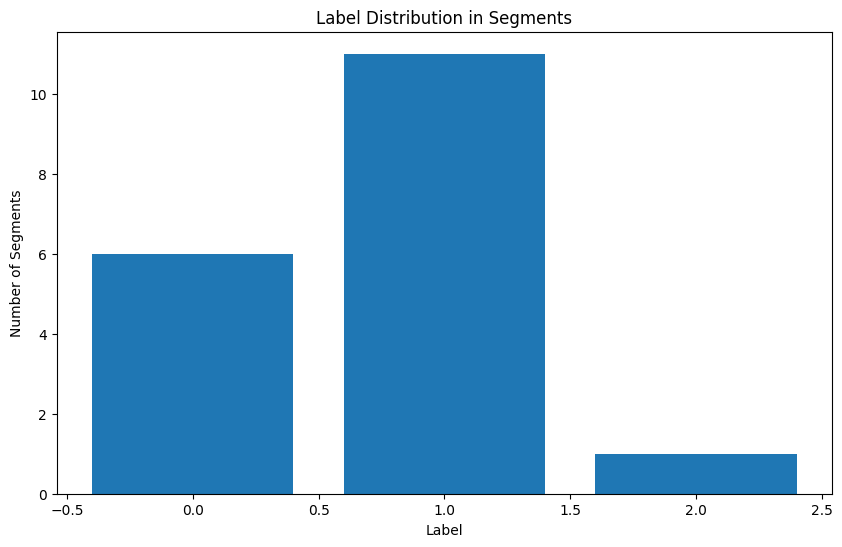


Original data label distribution:

Record label counts:
Label 0: 8
Label 1: 106
Label 2: 126

Record label counts:
Label 0: 180
Label 1: 155
Label 2: 25

Record label counts:
Label 0: 52
Label 1: 224
Label 2: 84

Record label counts:
Label 0: 108
Label 1: 133
Label 2: 29

Record label counts:
Label 0: 151
Label 1: 417
Label 2: 152

Record label counts:
Label 0: 162
Label 1: 502
Label 2: 56

Record label counts:
Label 0: 322
Label 1: 314
Label 2: 78

Record label counts:
Label 0: 316
Label 1: 289
Label 2: 89

Record label counts:
Label 0: 394
Label 1: 186
Label 2: 60

Record label counts:
Label 0: 75
Label 1: 612
Label 2: 11

Record label counts:
Label 0: 780

Record label counts:
Label 0: 760

Record label counts:
Label 0: 214
Label 1: 513
Label 2: 33

Record label counts:
Label 0: 140
Label 1: 203
Label 2: 115

Record label counts:
Label 0: 286
Label 1: 393
Label 2: 31

Record label counts:
Label 0: 124
Label 1: 414
Label 2: 182

Record label counts:
Label 0: 175
Label 1: 259
Label 2

In [5]:

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

#  Segmentation 


def find_optimal_window_size(signals, min_window=1000, max_window=5000):
    
    signal_length = len(signals)
    optimal_window = signal_length // 10  
    return min(max(optimal_window, min_window), max_window)


window_sizes = [find_optimal_window_size(record['signals']) for record in preprocessed_data]
overlap = max(window_sizes) // 2  


def segment_data(preprocessed_data, window_sizes, overlap):
    segmented_data = []
    
    for idx, record in enumerate(preprocessed_data):
        signals = record['signals']
        labels = record['labels']
        window_size = window_sizes[idx] 
        
       
        n_samples = len(signals)
        for i in range(0, n_samples - window_size, overlap):
            segment = signals[i:i + window_size]
            segment_labels = labels[i:i + window_size]
            
            
            if np.any(np.isnan(segment)) or np.any(np.isnan(segment_labels)):
                continue
                
            try:
                
                segment_label = stats.mode(segment_labels, keepdims=False)[0]
                if not np.isnan(segment_label):
                    segmented_data.append({
                        'segment': segment,
                        'label': int(segment_label),  
                        'start_idx': i,
                        'end_idx': i + window_size
                    })
            except TypeError:
                
                segment_label = stats.mode(segment_labels)[0][0]
                if not np.isnan(segment_label):
                    segmented_data.append({
                        'segment': segment,
                        'label': int(segment_label),  
                        'start_idx': i,
                        'end_idx': i + window_size
                    })
    
    return segmented_data

# Applying the segmentation with dynamic window sizes
segmented_data = segment_data(preprocessed_data, window_sizes, overlap)


if segmented_data:
    labels = [s['label'] for s in segmented_data]
    unique_labels = sorted(set(labels))  
    
   
    print(f"Unique labels in segments: {unique_labels}")
    print(f"\nLabel distribution:")
    
    
    for label in unique_labels:
        count = sum(1 for s in segmented_data if s['label'] == label)
        percentage = (count / len(segmented_data)) * 100
        

    
    print("\nData quality checks:")
    print(f"Number of segments with NaN signals: {sum(1 for s in segmented_data if np.any(np.isnan(s['segment'])))}")
    
    
    # Plotting label distribution
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, [sum(1 for s in segmented_data if s['label'] == label) for label in unique_labels])
    plt.title('Label Distribution in Segments')
    plt.xlabel('Label')
    plt.ylabel('Number of Segments')
    plt.show()
else:
    print("No valid segments were created. Check your data and segmentation parameters.")


print("\nOriginal data label distribution:")
for record in preprocessed_data:
    unique, counts = np.unique(record['labels'][~np.isnan(record['labels'])], return_counts=True)
    print(f"\nRecord label counts:")
    for u, c in zip(unique, counts):
        print(f"Label {int(u)}: {c}")


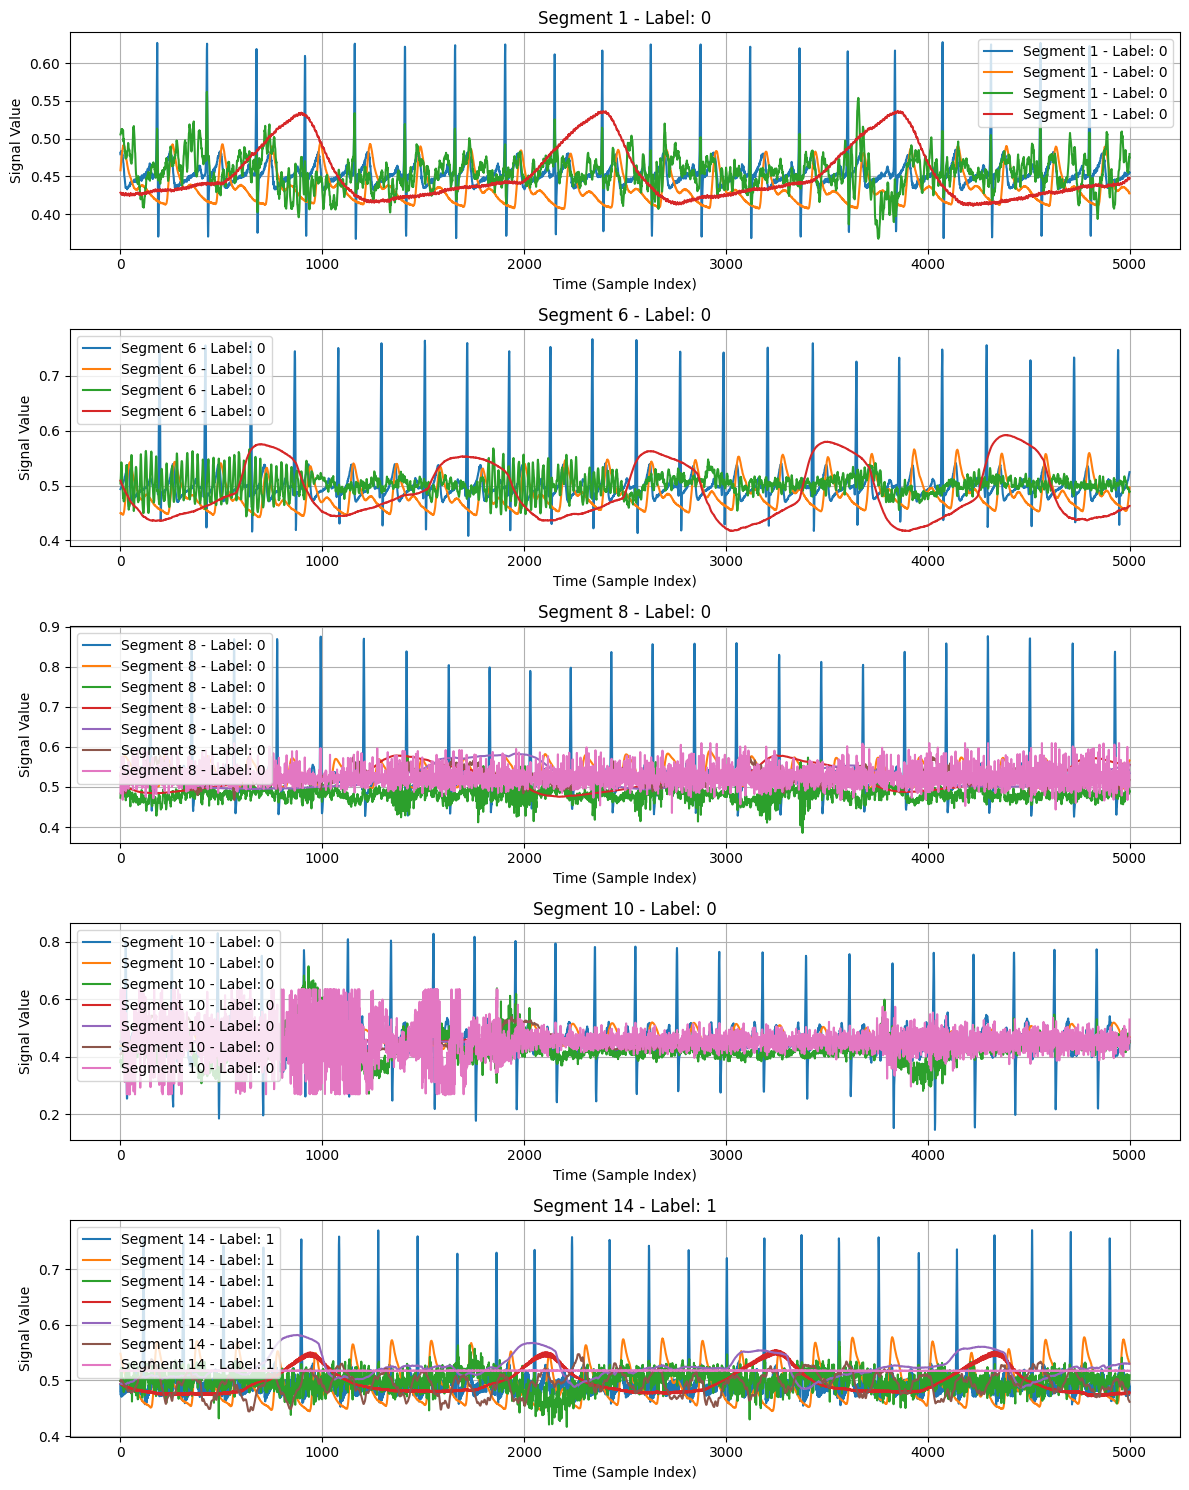

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#  Visualization of Sample Segments 

def plot_sample_segments(segmented_data, num_samples=5):

    
    if not segmented_data:
        print("No segmented data to visualize.")
        return
    
    # Choosing a random segments to visualize
    np.random.seed(0)  
    random_indices = np.random.choice(len(segmented_data), min(num_samples, len(segmented_data)), replace=False)
    
    plt.figure(figsize=(12, num_samples * 3))
    
    for idx, segment_index in enumerate(random_indices):
        segment = segmented_data[segment_index]['segment']
        label = segmented_data[segment_index]['label']
        
        plt.subplot(num_samples, 1, idx + 1)
        plt.plot(segment, label=f'Segment {segment_index} - Label: {label}')
        plt.title(f'Segment {segment_index} - Label: {label}')
        plt.xlabel('Time (Sample Index)')
        plt.ylabel('Signal Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_sample_segments(segmented_data, num_samples=5)


In [7]:
import numpy as np
from scipy.stats import skew, kurtosis

# Feature Extraction 

def extract_features(segment):
    
    features = []
    
    
    if segment.ndim > 1:
        segment = segment.flatten()
    
    
    features.append(np.mean(segment))
    
    
    features.append(np.std(segment))
    
 
    features.append(np.median(segment))
    
    
    features.append(skew(segment))
    
   
    features.append(kurtosis(segment))
    
    features.append(np.ptp(segment))
    
    
    
    return np.array(features)


X = [] 
y = []  
for data in segmented_data:
    segment = data['segment']
    label = data['label']
    
    # Extracting features and adding to the dataset
    features = extract_features(segment)
    
   
    if features.shape == (6,):  
        X.append(features)
        y.append(label)
    else:
        print(f"Skipping segment due to inconsistent feature size: {features.shape}")


X = np.array(X)
y = np.array(y)

print("Feature extraction completed.")



print("\nSample of extracted features:")
for i, feature_vector in enumerate(X[:6]):  # Displaying the first 5 feature vectors
    print(f"Sample {i + 1}: {feature_vector}")


Feature extraction completed.

Sample of extracted features:
Sample 1: [0.48938657 0.01013581 0.48857045 0.82098718 4.40678706 0.10613331]
Sample 2: [0.44925715 0.02804879 0.44500505 1.35337215 3.8345722  0.26034309]
Sample 3: [5.20741270e-01 1.71564316e-02 5.18463521e-01 2.28526543e+00
 2.05788263e+01 2.72756827e-01]
Sample 4: [ 4.43234461e-01  2.16308176e-02  4.41255704e-01 -1.00168787e-01
  2.83889773e+01  6.08917789e-01]
Sample 5: [0.52390809 0.02431759 0.52180706 1.46678237 7.63998848 0.29914044]
Sample 6: [0.46066133 0.03333579 0.45528121 0.54777843 2.64094196 0.34124134]


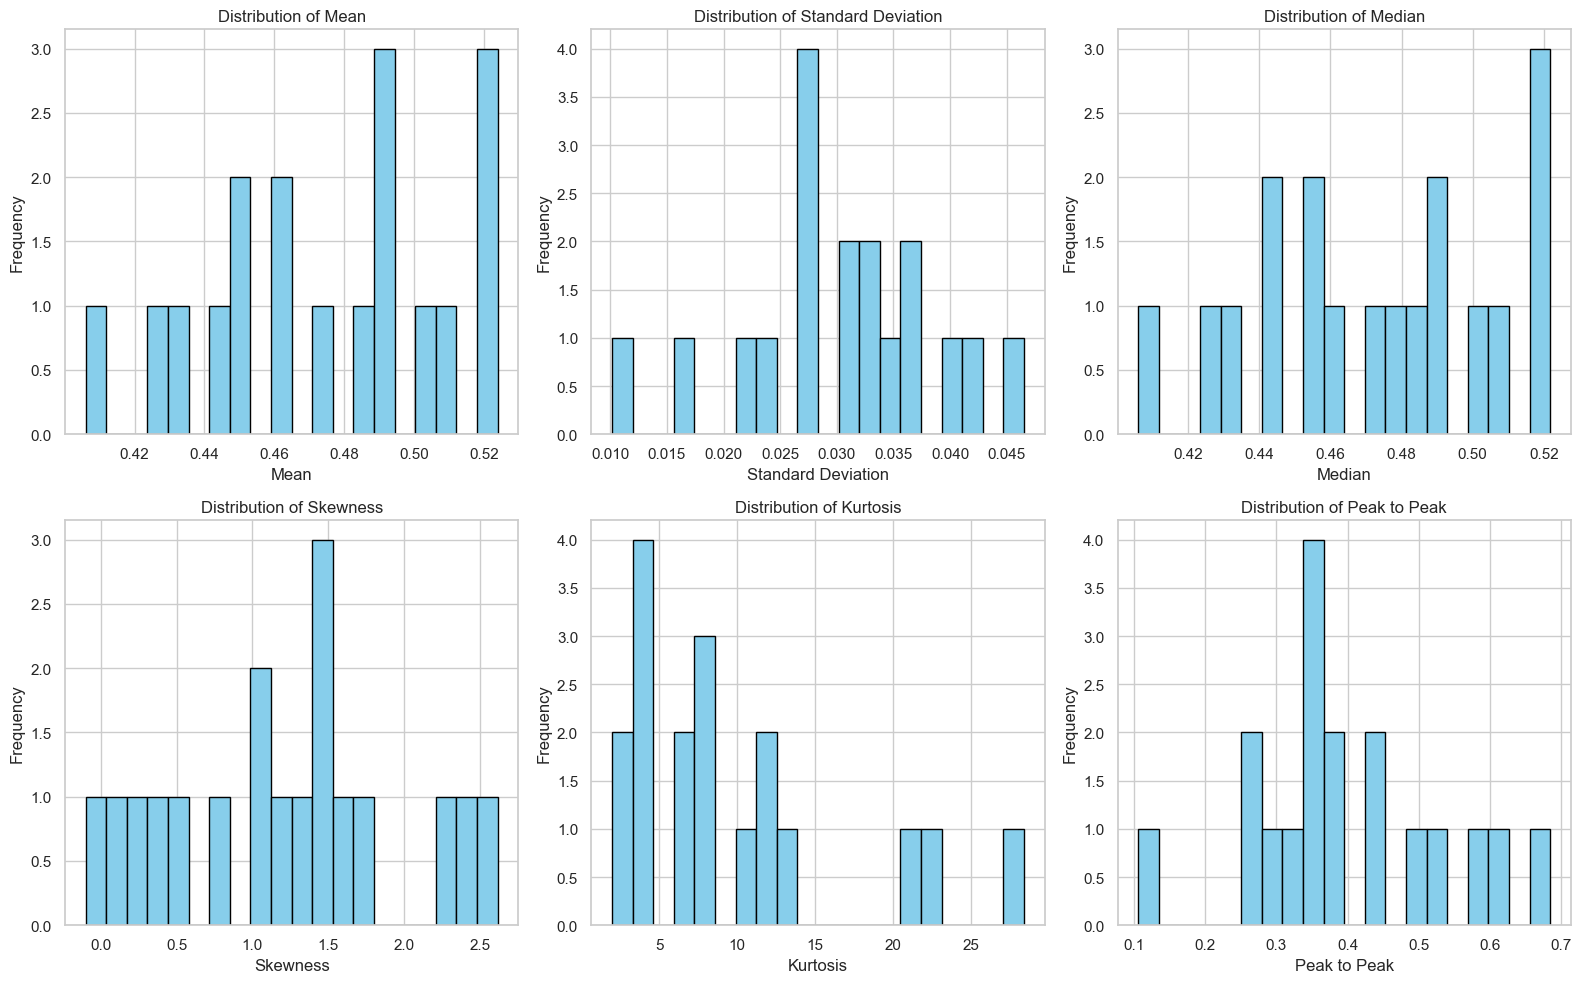

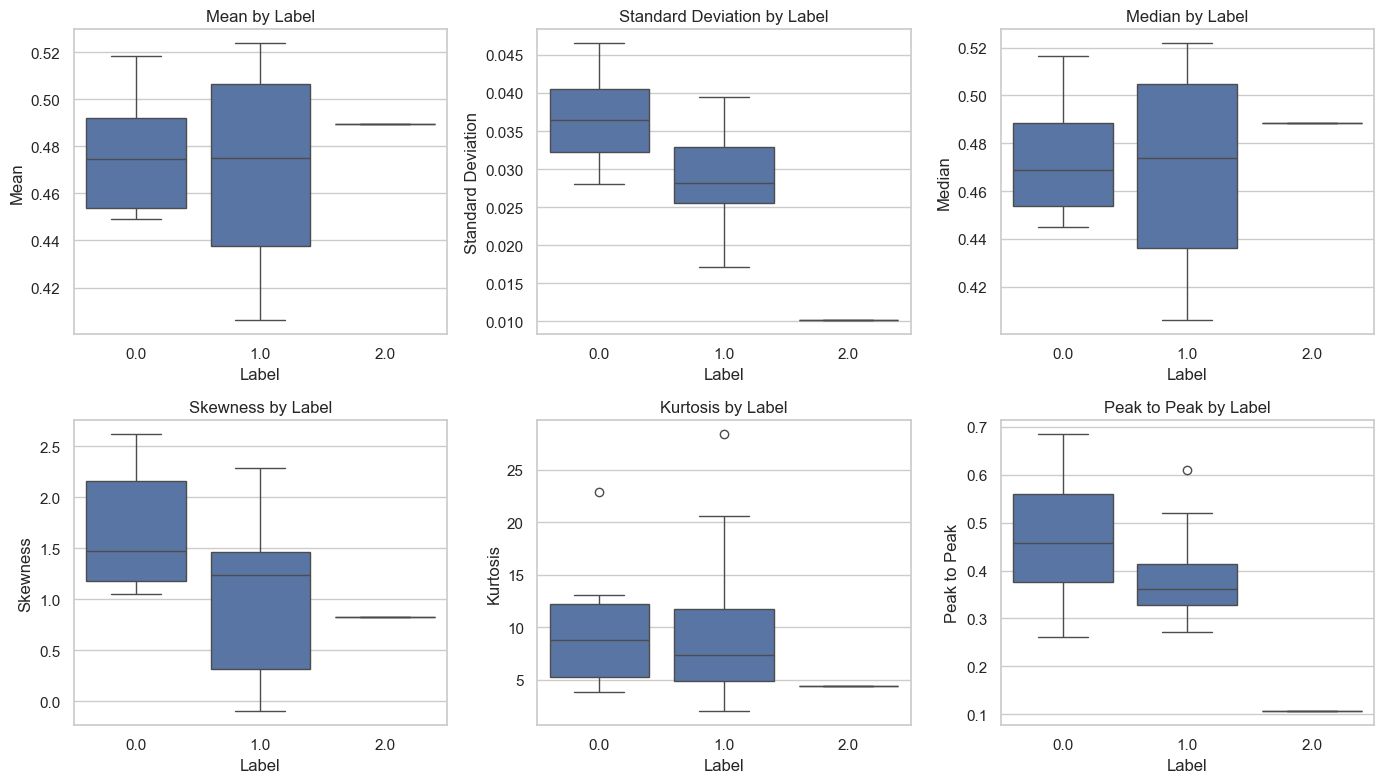

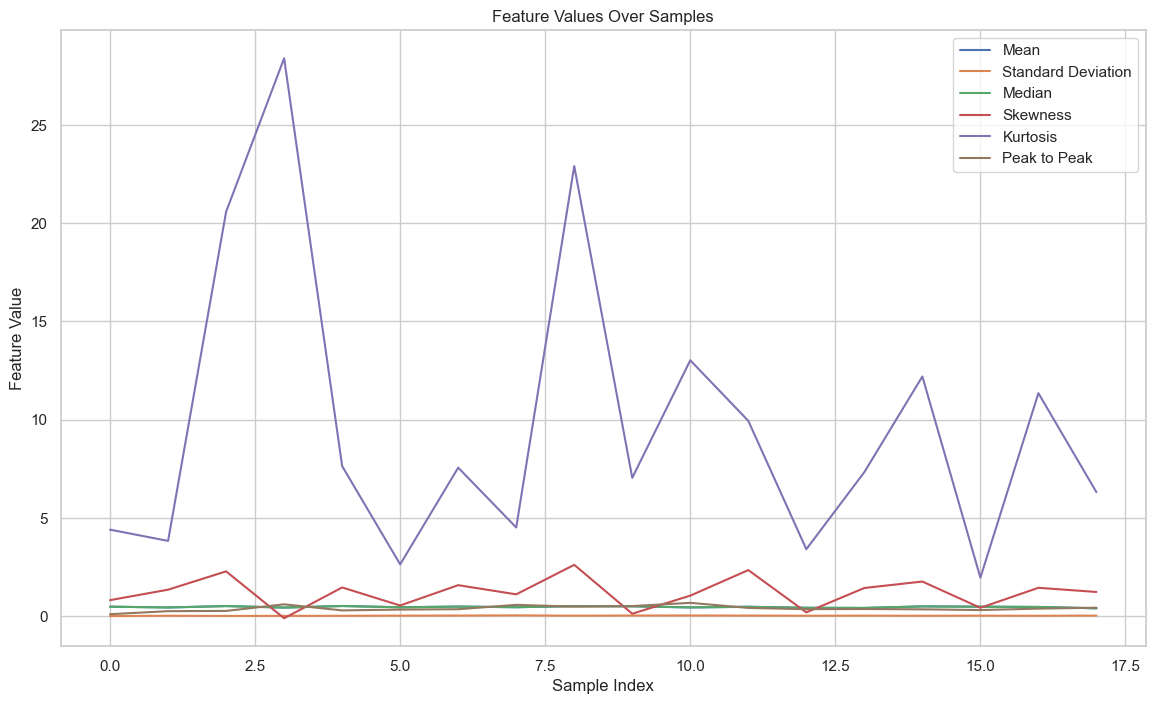

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

# histograms of each feature
def plot_feature_distributions(X):
    feature_names = ['Mean', 'Standard Deviation', 'Median', 'Skewness', 'Kurtosis','Peak to Peak']
    num_features = X.shape[1]

    plt.figure(figsize=(16, 10))
    for i in range(num_features):
        plt.subplot(2, 3, i + 1)
        plt.hist(X[:, i], bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {feature_names[i]}')
        plt.xlabel(f'{feature_names[i]}')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# boxplots of features by label
def plot_features_by_label(X, y):
    feature_names = ['Mean', 'Standard Deviation', 'Median', 'Skewness', 'Kurtosis','Peak to Peak']
    data = np.column_stack((X, y))
    num_features = X.shape[1]

    plt.figure(figsize=(14, 8))
    for i in range(num_features):
        plt.subplot(2, 3, i + 1)
        sns.boxplot(x=data[:, -1], y=data[:, i])
        plt.title(f'{feature_names[i]} by Label')
        plt.xlabel('Label')
        plt.ylabel(f'{feature_names[i]}')

    plt.tight_layout()
    plt.show()

# plot feature values over samples
def plot_features_over_samples(X):
    feature_names = ['Mean', 'Standard Deviation', 'Median', 'Skewness', 'Kurtosis','Peak to Peak']
    num_samples = X.shape[0]

    plt.figure(figsize=(14, 8))
    for i in range(X.shape[1]):
        plt.plot(range(num_samples), X[:, i], label=feature_names[i])
    
    plt.title('Feature Values Over Samples')
    plt.xlabel('Sample Index')
    plt.ylabel('Feature Value')
    plt.legend()
    plt.show()


plot_feature_distributions(X)
plot_features_by_label(X, y)
plot_features_over_samples(X)


In [9]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

label_en = LabelEncoder()  

label_en.fit(np.concatenate([y_train, y_test]))

y_train_encoded = label_en.transform(y_train)
y_test_encoded = label_en.transform(y_test)

n_hidden_states = 6
hmm_model = hmm.GaussianHMM(n_components=n_hidden_states, covariance_type="spherical", n_iter=100, random_state=42)

# Fit the model on training data
hmm_model.fit(X_train)
print("HMM training completed.")

startprob = hmm_model.startprob_  
transmat = hmm_model.transmat_  
means = hmm_model.means_  
covars = hmm_model.covars_  

print("\nInitial State Probabilities (startprob):")
print(startprob)

print("\nState Transition Probabilities (transmat):")
print(transmat)

print("\nMeans of Gaussian Distributions (means):")
print(means)

print("\nCovariance Matrices (covars):")
print(covars)

hidden_states = hmm_model.predict(X_test)

state_to_label = {}

for state in range(n_hidden_states):
    mask = (hidden_states == state)
    
    if np.any(mask): 
        common_label = np.bincount(y_test_encoded[mask]).argmax()
        state_to_label[state] = common_label
    else:
        state_to_label[state] = np.bincount(y_test_encoded).argmax()

predicted_la = [state_to_label[state] for state in hidden_states]  

predicted_la = label_en.inverse_transform(predicted_la)  

# Evaluating the HMM-based classification
print("Classification Report:")
report = classification_report(y_test, predicted_la, zero_division=1, output_dict=True)

for label in report:
    if isinstance(report[label], dict):
        del report[label]['support']

report_df = pd.DataFrame(report).transpose()
print(report_df)

accuracy = accuracy_score(y_test, predicted_la)
print(f"Accuracy: {accuracy * 100:.2f}%")

# EVALUATION USING DYNAMIC PROGRAMMING (FORWARD ALGORITHM)

log_likelihood = hmm_model.score(X_test)
print(f"\nLog Likelihood of the observed data sequence (using Forward Algorithm): {log_likelihood:.2f}")

# DECODING USING DYNAMIC PROGRAMMING (VITERBI ALGORITHM)

logprob, viterbi_path = hmm_model.decode(X_test, algorithm="viterbi")

viterbi_la = [state_to_label[state] for state in viterbi_path]  

viterbi_la = label_en.inverse_transform(viterbi_la)  

print("\nEvaluation using Viterbi Algorithm:")
viterbi_report = classification_report(y_test, viterbi_la, zero_division=1, output_dict=True)

for label in viterbi_report:
    if isinstance(viterbi_report[label], dict):
        del viterbi_report[label]['support']

viterbi_re_df = pd.DataFrame(viterbi_report).transpose()  
print(viterbi_re_df)

viterbi_accuracy = accuracy_score(y_test, viterbi_la)
print(f"Viterbi Accuracy: {viterbi_accuracy * 100:.2f}%")


HMM training completed.

Initial State Probabilities (startprob):
[8.61025840e-144 6.26124398e-259 1.00000000e+000 0.00000000e+000
 7.34652330e-209 2.25903339e-171]

State Transition Probabilities (transmat):
[[8.94244598e-029 7.47539139e-072 0.00000000e+000 2.49941517e-001
  2.50000000e-001 5.00058483e-001]
 [5.00000000e-001 5.00000000e-001 0.00000000e+000 3.29895335e-037
  2.21342200e-058 6.41695668e-037]
 [1.64341187e-087 3.43976723e-081 0.00000000e+000 1.36517012e-098
  1.00000000e+000 4.97050981e-096]
 [1.00000000e+000 6.70676926e-096 0.00000000e+000 4.62070930e-065
  1.38997405e-080 4.43912907e-036]
 [6.66666667e-001 3.33333333e-001 0.00000000e+000 3.90977726e-024
  2.87536457e-058 3.28152461e-039]
 [1.73022959e-100 1.09137443e-043 0.00000000e+000 5.00000000e-001
  5.00000000e-001 9.92937338e-107]]

Means of Gaussian Distributions (means):
[[ 0.91946291 -0.77210323  0.95451399  0.70900869  0.44674383 -0.51729098]
 [-0.50585422  1.59440276 -0.49172019 -0.16562042 -0.13262164  1.72

In [10]:


#  Decoding the sequence of sleep stages using Viterbi algorithm 


sleep_stage_mapping = {
    0: 'W',  # Wake
    1: '1',  # Sleep Stage 1
    2: '2',  # Sleep Stage 2
    3: '3',  # Sleep Stage 3
    4: '4',  # Sleep Stage 4
    5: 'R'   # REM Stage
}

# Decode the Viterbi path (hidden states) into sleep stages
predicted_sleep_stages = [sleep_stage_mapping[state] for state in viterbi_path]


print("\nPredicted sequence of sleep stages using Viterbi algorithm:")
print(predicted_sleep_stages[:4])  # Displaying the first 4 predictions



Predicted sequence of sleep stages using Viterbi algorithm:
['W', '4', 'W', 'R']


 Tried another approach by using the forward-backward smoothing in below code

In [11]:
# forward and backward
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

label_en = LabelEncoder()

label_en.fit(np.concatenate([y_train, y_test]))

y_train_encoded = label_en.transform(y_train)
y_test_encoded = label_en.transform(y_test)

n_hidden_states = 6
hmm_model = hmm.GaussianHMM(n_components=n_hidden_states, covariance_type="spherical", n_iter=100, random_state=42)

hmm_model.fit(X_train)
print("HMM training completed.")

startprob = hmm_model.startprob_  
transmat = hmm_model.transmat_  
means = hmm_model.means_  
covars = hmm_model.covars_

print("\nInitial State Probabilities (startprob):")
print(startprob)

print("\nState Transition Probabilities (transmat):")
print(transmat)

print("\nMeans of Gaussian Distributions (means):")
print(means)

print("\nCovariance Matrices (covars):")
print(covars)

hidden_states = hmm_model.predict(X_test)

state_to_label = {}

for state in range(n_hidden_states):
    
    mask = (hidden_states == state)
    
    if np.any(mask):  
        
        common_label = np.bincount(y_test_encoded[mask]).argmax()
        state_to_label[state] = common_label
    else:
        
        state_to_label[state] = np.bincount(y_test_encoded).argmax()

predicted_la = [state_to_label[state] for state in hidden_states]

predicted_la = label_en.inverse_transform(predicted_la)

print("Classification Report:")
report = classification_report(y_test, predicted_la, zero_division=1, output_dict=True)

for label in report:
    if isinstance(report[label], dict):
        del report[label]['support']

report_df = pd.DataFrame(report).transpose()

print(report_df)

accuracy = accuracy_score(y_test, predicted_la)
print(f"Accuracy: {accuracy * 100:.2f}%")

# EVALUATION USING DYNAMIC PROGRAMMING (FORWARD ALGORITHM) 

log_likelihood = hmm_model.score(X_test)
print(f"\nLog Likelihood of the observed data sequence (using Forward Algorithm): {log_likelihood:.2f}")

# DECODING USING DYNAMIC PROGRAMMING (VITERBI ALGORITHM) 

logprob, viterbi_path = hmm_model.decode(X_test, algorithm="viterbi")

viterbi_la = [state_to_label[state] for state in viterbi_path]

viterbi_la = label_en.inverse_transform(viterbi_la)

print("\nEvaluation using Viterbi Algorithm:")
viterbi_report = classification_report(y_test, viterbi_la, zero_division=1, output_dict=True)

for label in viterbi_report:
    if isinstance(viterbi_report[label], dict):
        del viterbi_report[label]['support']

viterbi_re_df = pd.DataFrame(viterbi_report).transpose()

print(viterbi_re_df)

viterbi_accuracy = accuracy_score(y_test, viterbi_la)
print(f"Viterbi Accuracy: {viterbi_accuracy * 100:.2f}%")

# FORWARD-BACKWARD ALGORITHM (Smoothing) 

def forward_pass(model, X):
    n_samples = X.shape[0]
    n_states = model.n_components
    
    alpha = np.zeros((n_samples, n_states))
    
    _, first_likelihood = model.score_samples(X[:1])
    first_likelihood = first_likelihood[0] if isinstance(first_likelihood[0], np.ndarray) else first_likelihood
    alpha[0, :] = model.startprob_ * first_likelihood
    
    for t in range(1, n_samples):
        
        _, likelihood = model.score_samples(X[t:t+1])
        likelihood = likelihood[0] if isinstance(likelihood[0], np.ndarray) else likelihood
        
        for j in range(n_states):
            alpha[t, j] = np.dot(alpha[t-1, :], model.transmat_[:, j]) * likelihood[j]
    
    return alpha


def backward_pass(model, X):
    n_samples = X.shape[0]
    n_states = model.n_components
    
    beta = np.zeros((n_samples, n_states))
    
    beta[n_samples-1, :] = 1
    
    for t in range(n_samples-2, -1, -1):
        for i in range(n_states):
            
            _, likelihood = model.score_samples(X[t+1:t+2])
            likelihood = likelihood[0] if isinstance(likelihood[0], np.ndarray) else likelihood
            
            beta[t, i] = np.dot(beta[t+1, :], model.transmat_[i, :] * likelihood)
    
    return beta

def forward_backward_smoothing(alpha, beta):
    
    smoothed_states = alpha * beta
    smoothed_states /= smoothed_states.sum(axis=1, keepdims=True)  
    return smoothed_states


alpha = forward_pass(hmm_model, X_test)
beta = backward_pass(hmm_model, X_test)

smoothed_states = forward_backward_smoothing(alpha, beta)

smoothed_hidden_states = np.argmax(smoothed_states, axis=1)

smoothed_labels = [state_to_label[state] for state in smoothed_hidden_states]

smoothed_labels = label_en.inverse_transform(smoothed_labels)

print("\nEvaluation using Forward-Backward Algorithm (Smoothing):")
smoothed_report = classification_report(y_test, smoothed_labels, zero_division=1, output_dict=True)

for label in smoothed_report:
    if isinstance(smoothed_report[label], dict):
        del smoothed_report[label]['support']

smoothed_report_df = pd.DataFrame(smoothed_report).transpose()

print(smoothed_report_df)

smoothed_accuracy = accuracy_score(y_test, smoothed_labels)
print(f"Forward-Backward Accuracy: {smoothed_accuracy * 100:.2f}%")


HMM training completed.

Initial State Probabilities (startprob):
[8.61025840e-144 6.26124398e-259 1.00000000e+000 0.00000000e+000
 7.34652330e-209 2.25903339e-171]

State Transition Probabilities (transmat):
[[8.94244598e-029 7.47539139e-072 0.00000000e+000 2.49941517e-001
  2.50000000e-001 5.00058483e-001]
 [5.00000000e-001 5.00000000e-001 0.00000000e+000 3.29895335e-037
  2.21342200e-058 6.41695668e-037]
 [1.64341187e-087 3.43976723e-081 0.00000000e+000 1.36517012e-098
  1.00000000e+000 4.97050981e-096]
 [1.00000000e+000 6.70676926e-096 0.00000000e+000 4.62070930e-065
  1.38997405e-080 4.43912907e-036]
 [6.66666667e-001 3.33333333e-001 0.00000000e+000 3.90977726e-024
  2.87536457e-058 3.28152461e-039]
 [1.73022959e-100 1.09137443e-043 0.00000000e+000 5.00000000e-001
  5.00000000e-001 9.92937338e-107]]

Means of Gaussian Distributions (means):
[[ 0.91946291 -0.77210323  0.95451399  0.70900869  0.44674383 -0.51729098]
 [-0.50585422  1.59440276 -0.49172019 -0.16562042 -0.13262164  1.72